In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torchvision import datasets, transforms

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

## Task 2.1

In [3]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder('../data/train', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.ImageFolder('../data/test', transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def train_and_plot(network, train_loader, test_loader, epochs=50, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(network.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)

    epoch_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in tqdm(range(epochs)):
        print("epoch:", epoch)
        network.train()
        running_loss = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)

        # eval mode
        network.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = network(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        scheduler.step(test_loss)
        average_test_loss = test_loss / len(test_loader)
        test_losses.append(average_test_loss)
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        print("test accuracy:", test_accuracy)
        print("test loss:", average_test_loss)

    # Print the final results
    print(f"Finished Training\nParameters: {sum(p.numel() for p in network.parameters())}")
    print(f"Final Training Loss: {epoch_losses[-1]:.4f}")
    print(f"Final Test Loss: {test_losses[-1]:.4f}")
    print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

    # Plotting Training and Test Losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(epoch_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return epoch_losses, test_losses, test_accuracies, network

In [5]:
class PlainNet18Corrected(nn.Module):
    def __init__(self, num_classes=10):
        super(PlainNet18Corrected, self).__init__()
        
        self.in_planes = 64 

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.initial_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
                        nn.Linear(512, 1000),
                        nn.Linear(1000, num_classes))

    def _make_layer(self, planes, blocks, stride):
        layers = []
        
        for _ in range(0, blocks):
            layers.append(nn.Conv2d(self.in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(planes))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(planes))
            layers.append(nn.ReLU(inplace=True))
            self.in_planes = planes
            stride = 1 

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        # print("1", x.shape) # 1 torch.Size([128, 64, 16, 16])
        x = self.initial_pool(x)
        # print("2", x.shape) # 2 torch.Size([128, 64, 8, 8])
        x = self.layer1(x)
        # print("3", x.shape) # 3 torch.Size([128, 64, 8, 8])
        x = self.layer2(x)
        # print("4", x.shape) # 4 torch.Size([128, 128, 4, 4])
        x = self.layer3(x)
        # print("5", x.shape) # 5 torch.Size([128, 256, 2, 2])
        x = self.layer4(x)
        # print("6", x.shape) # 6 torch.Size([128, 512, 1, 1])
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

plain_net_18_corrected = PlainNet18Corrected().to(device)

ModifiedResNet18


  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 0


  2%|▏         | 1/50 [00:09<07:37,  9.33s/it]

test accuracy: 49.08
test loss: 1.4042863030976886
epoch: 1


  4%|▍         | 2/50 [00:19<07:58,  9.97s/it]

test accuracy: 55.46
test loss: 1.2347864697251139
epoch: 2


  6%|▌         | 3/50 [00:30<08:10, 10.43s/it]

test accuracy: 59.08
test loss: 1.1606314589705649
epoch: 3


  8%|▊         | 4/50 [00:41<08:14, 10.76s/it]

test accuracy: 60.67
test loss: 1.1177552463133125
epoch: 4


 10%|█         | 5/50 [00:53<08:14, 10.98s/it]

test accuracy: 61.66
test loss: 1.1470126819007005
epoch: 5


 12%|█▏        | 6/50 [01:04<08:06, 11.05s/it]

test accuracy: 62.66
test loss: 1.1285907098009615
epoch: 6


 14%|█▍        | 7/50 [01:15<07:58, 11.12s/it]

test accuracy: 62.38
test loss: 1.1799773264534865
epoch: 7


 16%|█▌        | 8/50 [01:27<07:49, 11.17s/it]

test accuracy: 62.21
test loss: 1.1978448674648623
epoch: 8


 18%|█▊        | 9/50 [01:37<07:31, 11.01s/it]

test accuracy: 61.44
test loss: 1.3119640772855734
epoch: 9


 20%|██        | 10/50 [01:48<07:21, 11.05s/it]

test accuracy: 61.5
test loss: 1.3723174152494986
epoch: 10


 22%|██▏       | 11/50 [02:00<07:12, 11.10s/it]

test accuracy: 63.08
test loss: 1.360310271570954
epoch: 11


 24%|██▍       | 12/50 [02:11<07:01, 11.10s/it]

test accuracy: 62.14
test loss: 1.5084332454053662
epoch: 12


 26%|██▌       | 13/50 [02:22<06:50, 11.08s/it]

test accuracy: 63.38
test loss: 1.4170244502115854
epoch: 13


 28%|██▊       | 14/50 [02:33<06:42, 11.18s/it]

test accuracy: 63.29
test loss: 1.4739221153379995
epoch: 14


 30%|███       | 15/50 [02:44<06:29, 11.14s/it]

test accuracy: 62.67
test loss: 1.6121915284591386
epoch: 15


 32%|███▏      | 16/50 [02:56<06:21, 11.21s/it]

test accuracy: 66.0
test loss: 1.506877782978589
epoch: 16


 34%|███▍      | 17/50 [03:06<06:05, 11.09s/it]

test accuracy: 66.44
test loss: 1.63499769379821
epoch: 17


 36%|███▌      | 18/50 [03:17<05:54, 11.07s/it]

test accuracy: 66.32
test loss: 1.7318418523933314
epoch: 18


 38%|███▊      | 19/50 [03:29<05:43, 11.08s/it]

test accuracy: 66.04
test loss: 1.8208430975298338
epoch: 19


 40%|████      | 20/50 [03:39<05:30, 11.02s/it]

test accuracy: 65.86
test loss: 1.9209358933605725
epoch: 20


 42%|████▏     | 21/50 [03:51<05:21, 11.08s/it]

test accuracy: 66.13
test loss: 1.97677564319176
epoch: 21


 44%|████▍     | 22/50 [04:02<05:10, 11.08s/it]

test accuracy: 65.88
test loss: 2.0755780271337003
epoch: 22


 46%|████▌     | 23/50 [04:13<04:57, 11.01s/it]

test accuracy: 66.06
test loss: 2.132974493352673
epoch: 23


 48%|████▊     | 24/50 [04:24<04:45, 11.00s/it]

test accuracy: 66.04
test loss: 2.1599227099479
epoch: 24


 50%|█████     | 25/50 [04:34<04:33, 10.93s/it]

test accuracy: 65.88
test loss: 2.1914743999891644
epoch: 25


 52%|█████▏    | 26/50 [04:45<04:21, 10.91s/it]

test accuracy: 66.0
test loss: 2.2650483831574646
epoch: 26


 54%|█████▍    | 27/50 [04:56<04:13, 11.00s/it]

test accuracy: 66.17
test loss: 2.2337363913089416
epoch: 27


 56%|█████▌    | 28/50 [05:07<04:00, 10.95s/it]

test accuracy: 66.23
test loss: 2.243932275832454
epoch: 28


 58%|█████▊    | 29/50 [05:18<03:50, 10.96s/it]

test accuracy: 66.36
test loss: 2.2470847851113427
epoch: 29


 60%|██████    | 30/50 [05:29<03:39, 11.00s/it]

test accuracy: 66.59
test loss: 2.24856225146523
epoch: 30


 62%|██████▏   | 31/50 [05:40<03:30, 11.06s/it]

test accuracy: 66.33
test loss: 2.24935195264937
epoch: 31


 64%|██████▍   | 32/50 [05:52<03:19, 11.11s/it]

test accuracy: 66.4
test loss: 2.2644859733460825
epoch: 32


 66%|██████▌   | 33/50 [06:03<03:08, 11.07s/it]

test accuracy: 66.33
test loss: 2.2867255452313002
epoch: 33


 68%|██████▊   | 34/50 [06:14<02:57, 11.06s/it]

test accuracy: 66.42
test loss: 2.2835819630683223
epoch: 34


 70%|███████   | 35/50 [06:24<02:44, 10.95s/it]

test accuracy: 66.29
test loss: 2.3069398795502094
epoch: 35


 72%|███████▏  | 36/50 [06:35<02:32, 10.92s/it]

test accuracy: 66.45
test loss: 2.302312645731093
epoch: 36


 74%|███████▍  | 37/50 [06:47<02:24, 11.09s/it]

test accuracy: 66.34
test loss: 2.2974818748763846
epoch: 37


 76%|███████▌  | 38/50 [06:58<02:13, 11.12s/it]

test accuracy: 66.55
test loss: 2.2892283729360074
epoch: 38


 78%|███████▊  | 39/50 [07:09<02:02, 11.13s/it]

test accuracy: 66.4
test loss: 2.299850976919826
epoch: 39


 80%|████████  | 40/50 [07:21<01:52, 11.23s/it]

test accuracy: 66.51
test loss: 2.30042192905764
epoch: 40


 82%|████████▏ | 41/50 [07:32<01:41, 11.25s/it]

test accuracy: 66.53
test loss: 2.308840297445466
epoch: 41


 84%|████████▍ | 42/50 [07:43<01:29, 11.20s/it]

test accuracy: 66.48
test loss: 2.3007426593877094
epoch: 42


 86%|████████▌ | 43/50 [07:54<01:18, 11.15s/it]

test accuracy: 66.74
test loss: 2.304431088363068
epoch: 43


 88%|████████▊ | 44/50 [08:05<01:06, 11.02s/it]

test accuracy: 66.47
test loss: 2.2996272210833393
epoch: 44


 90%|█████████ | 45/50 [08:15<00:54, 10.93s/it]

test accuracy: 66.52
test loss: 2.29801978189734
epoch: 45


 92%|█████████▏| 46/50 [08:27<00:43, 11.00s/it]

test accuracy: 66.62
test loss: 2.303268206270435
epoch: 46


 94%|█████████▍| 47/50 [08:38<00:33, 11.04s/it]

test accuracy: 66.51
test loss: 2.316539141196239
epoch: 47


 96%|█████████▌| 48/50 [08:49<00:22, 11.10s/it]

test accuracy: 66.48
test loss: 2.321802471257463
epoch: 48


 98%|█████████▊| 49/50 [09:00<00:11, 11.11s/it]

test accuracy: 66.59
test loss: 2.3145900904377803
epoch: 49


100%|██████████| 50/50 [09:12<00:00, 11.04s/it]

test accuracy: 66.42
test loss: 2.305746504023105
Finished Training
Parameters: 11525698
Final Training Loss: 0.0013
Final Test Loss: 2.3057
Final Test Accuracy: 66.42%


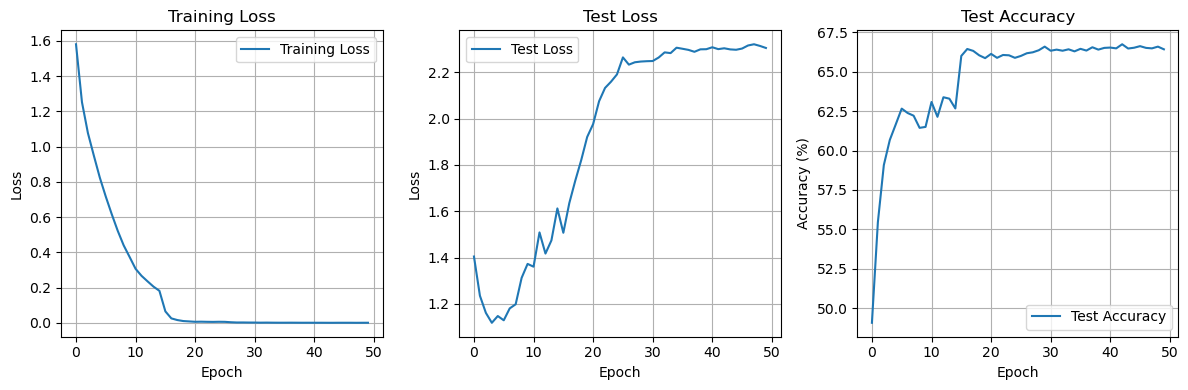

In [6]:
print("ModifiedResNet18")
training_losses1, testing_losses1, acc1, network1 = train_and_plot(plain_net_18_corrected, train_loader, test_loader)